Date: 2016-09-26

In [53]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import itertools
import functools
import scipy.fftpack
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import tqdm
import dask
import dask.multiprocessing

sys.path.append('../src/')
import data_filter
import ripples
import spectral

## Testing PETH plotting

In [2]:
def sim_poisson(rate, sampling_frequency=1000):
    y = np.random.uniform(size=rate.shape) <= (rate / sampling_frequency);
    return y.astype(int)

sampling_frequency = 1500
window_offset = (-0.500, 0.500)
num_trials = 500
before_zero_firing_rate = 1
after_zero_firing_rate = 10

num_time_points = ((window_offset[1] - window_offset[0]) * sampling_frequency) + 1
time = np.linspace(window_offset[0], window_offset[1], num=num_time_points)
time_before_zero_ind = np.where(time < 0)
time_after_zero_ind = np.where(time >= 0)
rate = np.concatenate((before_zero_firing_rate * np.ones((time_before_zero_ind[0].size, num_trials), float),
                       after_zero_firing_rate * np.ones((time_after_zero_ind[0].size, num_trials), float)),
                      axis=0)
spikes = sim_poisson(rate, sampling_frequency=1500)
simulated_spike_times = time[spikes.nonzero()[0]]

(-0.5, 0.5)

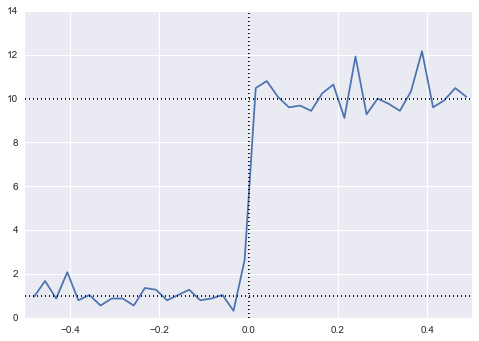

In [3]:
bin_size = 0.025 # in seconds
spike_times = time[spikes.nonzero()[0]]
number_of_bins = np.fix((window_offset[1] - window_offset[0]) / bin_size).astype(int)
bin_count, bins = np.histogram(spike_times, bins=number_of_bins)

rate = bin_count / (bin_size * num_trials)
plt.plot(bins[:-1] + (bin_size / 2), rate)
plt.axhline(before_zero_firing_rate, color='black', linestyle=':')
plt.axhline(after_zero_firing_rate, color='black', linestyle=':')
plt.axvline(0, color='black', linestyle=':')
plt.xlim(window_offset)

(-0.5, 0.5)

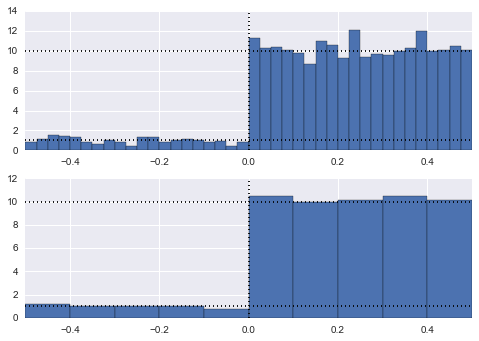

In [4]:
def peri_event_time_histogram(spike_times, time_extent,
                              number_of_trials=1, bin_size=0.025,
                              normalized=False):
    ''' Returns the histogram of spike times
    
    Parameters:
        spike_times: An indicator array with the time of spikes
        time_extent: A tuple of start and end time of the time period
                     under consideration
        bin_size: The size of the histogram time bins. Must be in the
                  same units as the time extent
        normalized: boolean where True means the firing rate is normalized
                    by its maximum firing rate
                     
    Returns:
        rate: The firing rate for each bin
        bins: The left edge of each histogram time bin
    '''
    number_of_bins = np.fix((time_extent[1] - time_extent[0]) / bin_size).astype(int)
    bin_count, bins = np.histogram(spike_times, bins=number_of_bins, range=time_extent)
    rate = bin_count / (bin_size * number_of_trials)
    if normalized:
        rate = rate / rate.max()
        
    return rate, bins


window_offset = (-0.500, 0.500)
spike_times = time[spikes.nonzero()[0]]
rate, bins = peri_event_time_histogram(spike_times, window_offset,
                                       number_of_trials=num_trials)

fig = plt.figure

ax1 = plt.subplot(2,1,1)
ax1.bar(bins[:-1], rate, width=0.025)
ax1.axhline(before_zero_firing_rate, color='black', linestyle=':')
ax1.axhline(after_zero_firing_rate, color='black', linestyle=':')
ax1.axvline(0, color='black', linestyle=':')
ax1.set_xlim(window_offset)

rate, bins = peri_event_time_histogram(spike_times, window_offset,
                                       number_of_trials=num_trials,
                                       bin_size=0.100)

ax2 = plt.subplot(2,1,2)
ax2.bar(bins[:-1], rate, width=0.100)
ax2.axhline(before_zero_firing_rate, color='black', linestyle=':')
ax2.axhline(after_zero_firing_rate, color='black', linestyle=':')
ax2.axvline(0, color='black', linestyle=':')
ax2.set_xlim(window_offset)

(-0.5, 0.5)

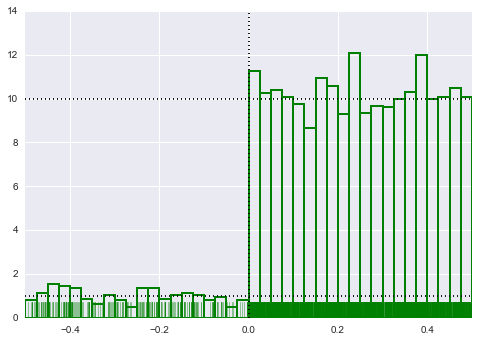

In [5]:
def plot_peri_event_time_histogram(spike_times, time_extent, normalized=False,
                                   number_of_trials=1, bin_size=0.025,
                                   color=None, axlabel=None,
                                   label=None, ax=None, rug=False):
    if ax is None:
        ax = plt.gca()
    if color is None:
        line, = ax.plot(spikes.mean(), 0)
        color = line.get_color()
        line.remove()

    rate, bins = peri_event_time_histogram(spike_times, time_extent,
                                           number_of_trials=number_of_trials,
                                           bin_size=bin_size,
                                           normalized=normalized)
    ax.bar(bins[:-1], rate,
           width=bin_size,
           edgecolor=color,
           linewidth=2,
           fill=False)
    if rug:
        sns.rugplot(spike_times, ax=ax, color=color, alpha=0.4)

spike_times = time[spikes.nonzero()[0]]
plot_peri_event_time_histogram(spike_times, window_offset,
                               number_of_trials=num_trials,
                               bin_size=0.025,
                               color='green', rug=True)
plt.axhline(before_zero_firing_rate, color='black', linestyle=':')
plt.axhline(after_zero_firing_rate, color='black', linestyle=':')
plt.axvline(0, color='black', linestyle=':')
plt.xlim(window_offset)

(-0.5, 0.5)

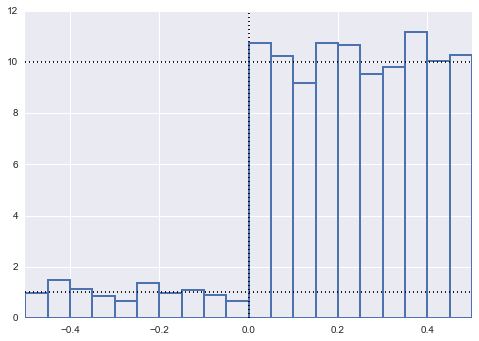

In [6]:
plot_peri_event_time_histogram(spike_times, window_offset,
                               number_of_trials=num_trials, bin_size=0.050)
plt.axhline(before_zero_firing_rate, color='black', linestyle=':')
plt.axhline(after_zero_firing_rate, color='black', linestyle=':')
plt.axvline(0, color='black', linestyle=':')
plt.xlim(window_offset)

(-0.5, 0.5)

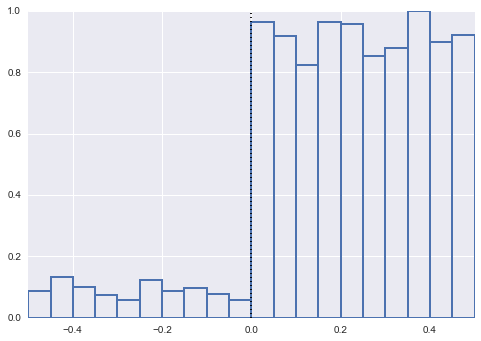

In [7]:
plot_peri_event_time_histogram(spike_times, window_offset,
                               number_of_trials=num_trials, bin_size=0.050,
                               normalized=True)
plt.axvline(0, color='black', linestyle=':')
plt.xlim(window_offset)

## Ripple Triggered PETH
### Multitaper-defined ripples

In [106]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = data_filter.make_epochs_dataframe(animals, days)
tetrode_info = data_filter.make_tetrode_dataframe(animals)
epoch_keys = data_filter.get_dataframe_index(epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

cur_tetrode_info = pd.concat([tetrode_info[key] for key in epoch_keys])
cur_tetrode_info


area  depth descrip  numcells tetrode_id
animal day epoch_ind tetrode_number                                          
HPa    8   2         1                CA1    113  riptet        12     HPa821
                     2                CA1    121     NaN         0     HPa822
                     3                CA1     90  CA1Ref         0     HPa823
                     4                CA1    116  riptet        15     HPa824
                     5                CA1    116  riptet         0     HPa825
                     6                CA1    110  riptet         0     HPa826
                     7                CA1    114  riptet         0     HPa827
                     8               iCA1    114  riptet         0     HPa828
                     9               iCA1    100  riptet         0     HPa829
                     10              iCA1     96     NaN         0    HPa8210
                     11              iCA1    106  riptet         0    HPa8211
                     12              iCA1    114  riptet         3    HPa8212
                     13              iCA1    120     NaN         0    HPa8213
                     14              iCA1    105  riptet         6    HPa8214
                     15               PFC     93     NaN         0    HPa8215
                     16               PFC     90     NaN         0    HPa8216
                     17               PFC     90     NaN         6    HPa8217
                     18               PFC     90     NaN         0    HPa8218
                     19               PFC    130     NaN         0    HPa8219
                     20               PFC    109     NaN         0    HPa8220

In [9]:
neuron_info = data_filter.make_neuron_dataframe(animals)
cur_neuron_info = pd.concat([neuron_info[key] for key in epoch_keys]).dropna().query('numspikes > 0')
cur_neuron_info

area                   csi  \
animal day epoch_ind tetrode_number neuron_number                               
HPa    8   2         1              2               CA1   0.05963302752293578   
                                    3               CA1   0.19162790697674417   
                                    4               CA1   0.08121019108280254   
                                    5               CA1   0.14817320703653586   
                                    6               CA1    0.1690929451287794   
                                    7               CA1  0.053475935828877004   
                     4              1               CA1   0.09773936170212766   
                                    2               CA1   0.13846153846153847   
                                    3               CA1    0.1411764705882353   
                                    4               CA1   0.11428571428571428   
                                    5               CA1   0.04081632653061224   
                                    6               CA1   0.02981651376146789   
                                    7               CA1   0.16352201257861634   
                                    8               CA1   0.16104868913857678   
                     12             1              iCA1   0.02631578947368421   
                                    2              iCA1   0.04430379746835443   
                                    3              iCA1  0.053717494811378344   
                     14             1              iCA1   0.06834268977300463   
                                    2              iCA1   0.07884972170686456   
                                    3              iCA1  0.048678720445062586   
                                    6              iCA1   0.09302325581395349   
                     17             1               PFC  0.014189693801344288   
                                    3               PFC                     0   
                                    4               PFC  0.008634868421052632   
                                    5               PFC   0.00519311911716975   
                                    6               PFC  0.004267668146124957   

                                                              meanrate  \
animal day epoch_ind tetrode_number neuron_number                        
HPa    8   2         1              2               0.7218543046357616   
                                    3               0.8899006622516556   
                                    4               0.5198675496688742   
                                    5                2.447019867549669   
                                    6               0.7392384105960265   
                                    7              0.15480132450331127   
                     4              1               1.2450331125827814   
                                    2               1.1837748344370862   
                                    3               0.7740066225165563   
                                    4              0.23178807947019867   
                                    5              0.20281456953642385   
                                    6               0.3609271523178808   
                                    7               0.1316225165562914   
                                    8              0.22102649006622516   
                     12             1              0.06291390728476821   
                                    2               0.3923841059602649   
                                    3                6.780629139072848   
                     14             1               3.3915562913907285   
                                    2               2.6771523178807946   
                                    3               0.5951986754966887   
                                    6              0.10678807947019868   
                     17             1               1.1084437086092715   
      

In [10]:
data_filter.get_spikes_dataframe(cur_neuron_info.index[1], animals)

,is_spike
time,
2713.1716,1
2713.9817,1
2715.5873,1
2715.5928,1
2715.5987,1
2715.6064,1
2715.6126,1
2730.9728,1
2732.0596,1


In [11]:
cur_tetrode_info = pd.concat([tetrode_info[key] for key in epoch_keys])
tetrode_index = data_filter.get_dataframe_index(cur_tetrode_info)
lfp_data = data_filter.get_LFP_data(tetrode_index, animals)
segments_multitaper = np.load('segments_multitaper.npy')
merged_segments = list(ripples.merge_ranges([seg for tetrode in segments_multitaper
                                         for seg in tetrode]))

speed_threshold = 4
position_dataframe = data_filter.get_position_dataframe(epoch_keys, animals)[0]
interpolated_position = (pd.concat([lfp_data[0], position_dataframe])
                            .sort_index()
                            .interpolate(method='linear')
                            .reindex(lfp_data[0].index))

average_speed = np.array([interpolated_position.loc[segment_start:segment_end, :].smoothed_speed.mean()
                 for segment_start, segment_end in merged_segments])
ripple_times = [merged_segments[i] for i in np.where(average_speed <= speed_threshold)[0]]

In [12]:
window_offset = (-0.500, 0.500)
spikes_data = [data_filter.get_spikes_dataframe(neuron_ind, animals)
               for neuron_ind in cur_neuron_info.index]
spike_segments = list(ripples.reshape_to_segments(spikes_data, ripple_times, window_offset))

(-0.5, 0.5)

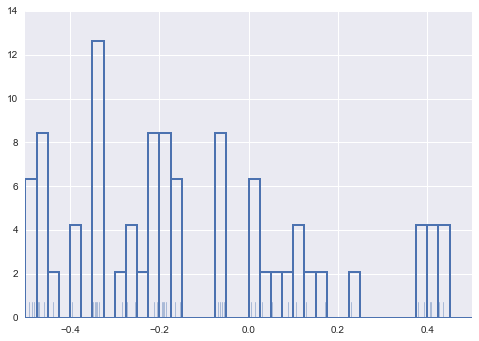

In [13]:
def get_spike_times(spike_dataframe):
    return spike_dataframe.reset_index().time.values

number_of_trials = len(ripple_times)
spike_times = get_spike_times(spike_segments[0])

plot_peri_event_time_histogram(spike_times, window_offset,
                               number_of_trials=number_of_trials,
                               bin_size=0.025,
                               rug=True)
plt.xlim(window_offset)

In [14]:
neuron_labels = cur_neuron_info.set_index(['area', 'neuron_id'], append=True).index
labeled_spike_segments = pd.concat(spike_segments,
                                   keys=neuron_labels,
                                   names=neuron_labels.names)
labeled_spike_segments

is_spike
animal day epoch_ind tetrode_number neuron_number area neuron_id segment_number segment_start segment_end time             
HPa    8   2         1              2             CA1  HPa8212   1              2794.348845   2794.372845 -0.2121         1
                                                                                                          -0.2012         1
                                                                                                          -0.1944         1
                                                                                                          -0.1904         1
                                                                                                          -0.0690         1
                                                                                                          -0.0648         1
                                                                                                          -0.0604         1
                                                                                                          -0.0547         1
                                                                                                           0.1062         1
                                                                 2              2794.628845   2794.652845 -0.4921         1
                                                                                                          -0.4812         1
                                                                                                          -0.4744         1
                                                                                                          -0.4704         1
                                                                                                          -0.3490         1
                                                                                                          -0.3448         1
                                                                                                          -0.3404         1
                                                                                                          -0.3347         1
                                                                                                          -0.1738         1
                                                                 3              2795.676846   2795.740846  0.0142         1
                                                                                                           0.0293         1
                                                                                                           0.1280         1
                                                                                                           0.1701         1
                                                                 4              2796.032846   2796.056846 -0.3418         1
                                                                                                          -0.3267         1
                                                                                                          -0.2280         1
                                                                                                          -0.1859         1
                                                                                                           0.3784         1
                                                                                                           0.3919         1
                                                                                                           0.4065         1
                                                                                                           0.4260         1
...                                                                                                                     ...
                     17

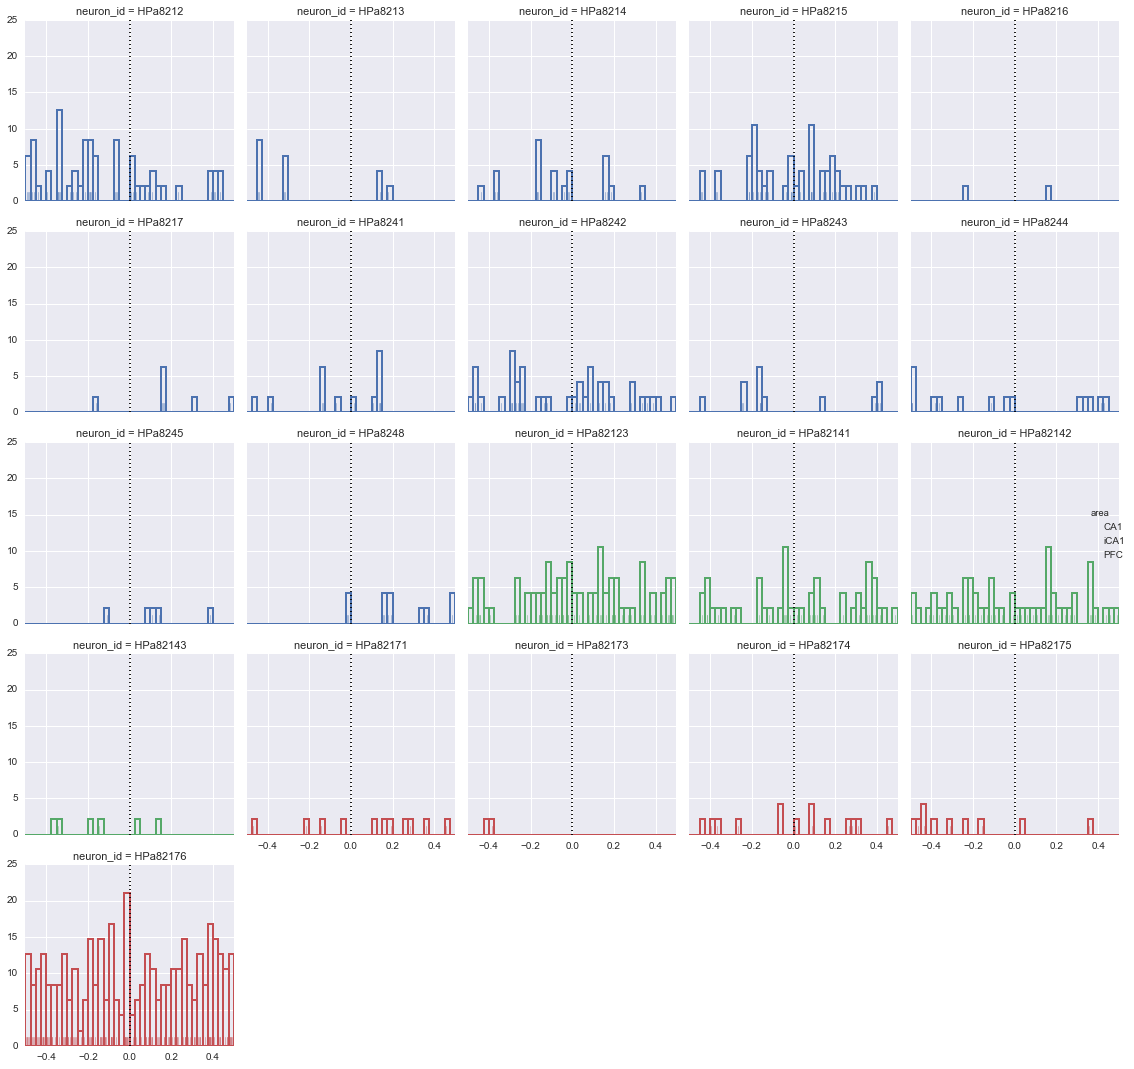

In [15]:
def peth_wrap(time_extent, number_of_trials, **kwargs):
    dataframe = kwargs.pop('data')
    spike_times = get_spike_times(dataframe)
    plot_peri_event_time_histogram(spike_times, time_extent,
                                   number_of_trials=number_of_trials,
                                   **kwargs)

grid = sns.FacetGrid(labeled_spike_segments.reset_index(), col='neuron_id', col_wrap=5, hue='area')
grid.map_dataframe(peth_wrap, window_offset, len(ripple_times), rug=True)
grid.set(xlim=window_offset);
grid.add_legend();
grid.map(plt.axvline, x=0, color='black', ls=':')

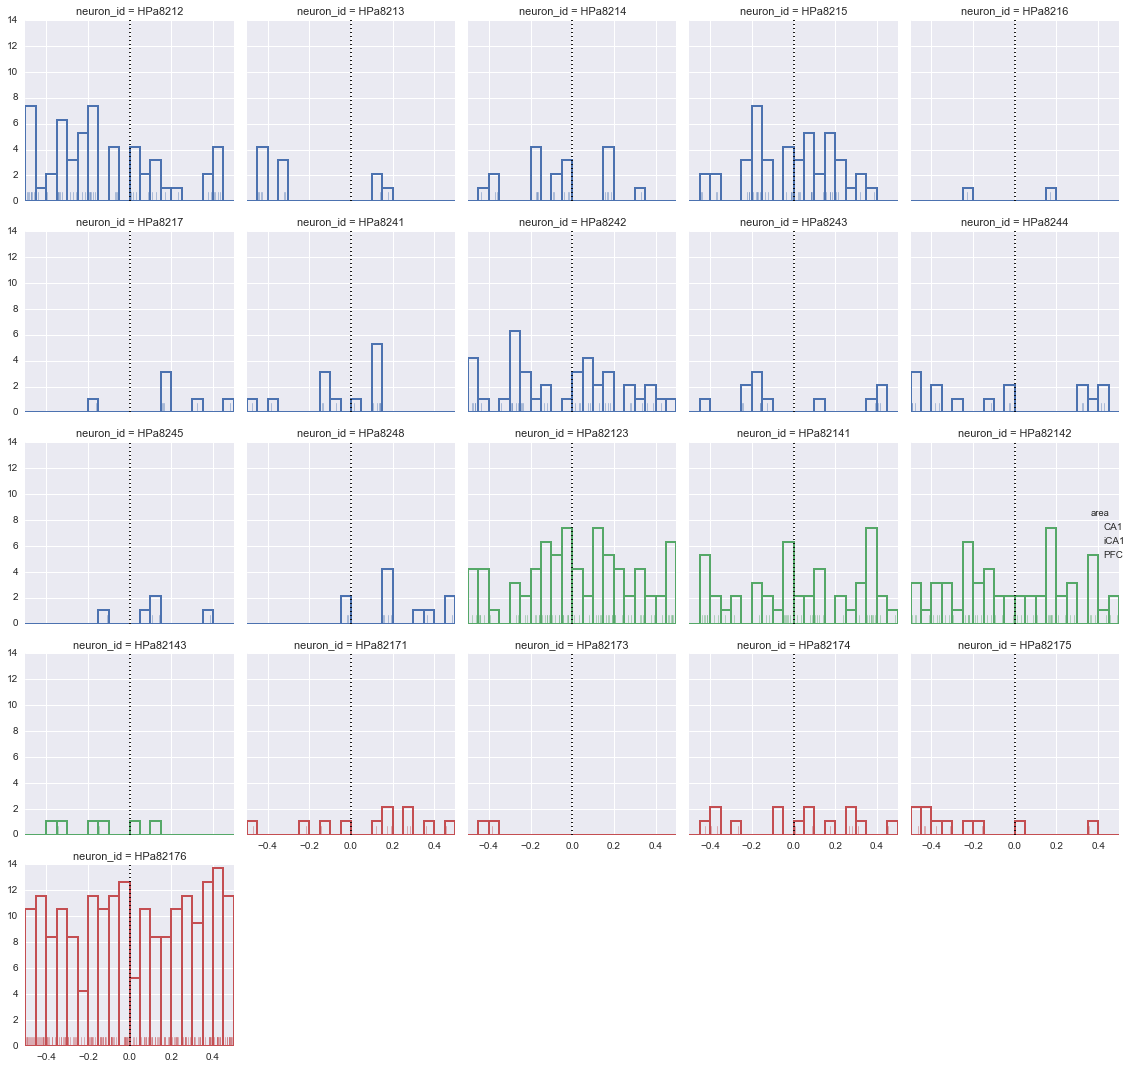

In [16]:
grid = sns.FacetGrid(labeled_spike_segments.reset_index(), col='neuron_id', col_wrap=5, hue='area')
grid.map_dataframe(peth_wrap, window_offset, len(ripple_times), bin_size=0.050, rug=True)
grid.set(xlim=window_offset);
grid.add_legend();
grid.map(plt.axvline, x=0, color='black', ls=':')

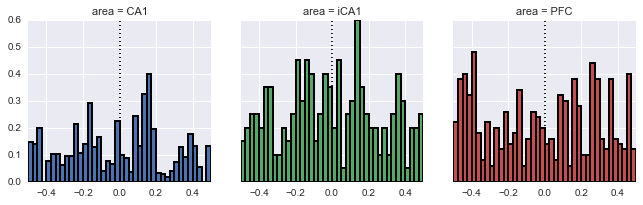

In [17]:
def compute_population_dataframe(x, time_extent, **kwargs):
    rate, bins = peri_event_time_histogram(x.time, time_extent,
                                           **kwargs)
    
    result = {'rate': rate, 'time': bins[:-1], 'area': x.area.iloc[0]}
    return pd.DataFrame(result)

def compute_population_rate(spike_dataframe, time_extent, number_of_trials=1):
    return (spike_dataframe
              .reset_index()
              .groupby('neuron_id')
              .apply(compute_population_dataframe, time_extent,
                     number_of_trials=len(ripple_times),
                     normalized=True,
                     )
              .groupby(['area', 'time'])
              .mean())

population_rate = compute_population_rate(labeled_spike_segments, window_offset, len(ripple_times))
grid = sns.FacetGrid(population_rate.reset_index(),
                     col='area', col_wrap=5, hue='area',
                     col_order=['CA1', 'iCA1', 'PFC'],
                     hue_order=['CA1', 'iCA1', 'PFC'])
grid.map(plt.bar, 'time', 'rate', width=0.025,
         linewidth=2)
grid.map(plt.axvline, x=0, color='black', ls=':')
grid.set(xlim=window_offset)

### Their Ripples

In [18]:
frank_individual_ripple_times = [ripples._get_computed_ripple_times(tetrode_tuple, animals)
                                 for tetrode_tuple in data_filter.get_dataframe_index(cur_tetrode_info[cur_tetrode_info.area == 'CA1'])]
merged_frank_segments = list(ripples.merge_ranges([seg for tetrode in frank_individual_ripple_times
                                         for seg in tetrode]))

speed_threshold = 4
interpolated_position = (pd.concat([lfp_data[0], position_dataframe])
                            .sort_index()
                            .interpolate(method='linear')
                            .reindex(lfp_data[0].index))

frank_average_speed = np.array([interpolated_position.loc[segment_start:segment_end, :].smoothed_speed.mean()
                                for segment_start, segment_end in merged_frank_segments])
frank_ripple_times = [merged_frank_segments[i] for i in np.where(frank_average_speed <= speed_threshold)[0]]


window_offset  = (-0.500, 0.500)
spikes_data = [data_filter.get_spikes_dataframe(neuron_ind, animals)
               for neuron_ind in cur_neuron_info.index]
frank_spike_segments = list(ripples.reshape_to_segments(spikes_data, frank_ripple_times, window_offset))

In [19]:
neuron_labels = cur_neuron_info.set_index(['area', 'neuron_id'], append=True).index
frank_labeled_spike_segments = pd.concat(frank_spike_segments,
                                         keys=neuron_labels,
                                         names=neuron_labels.names)

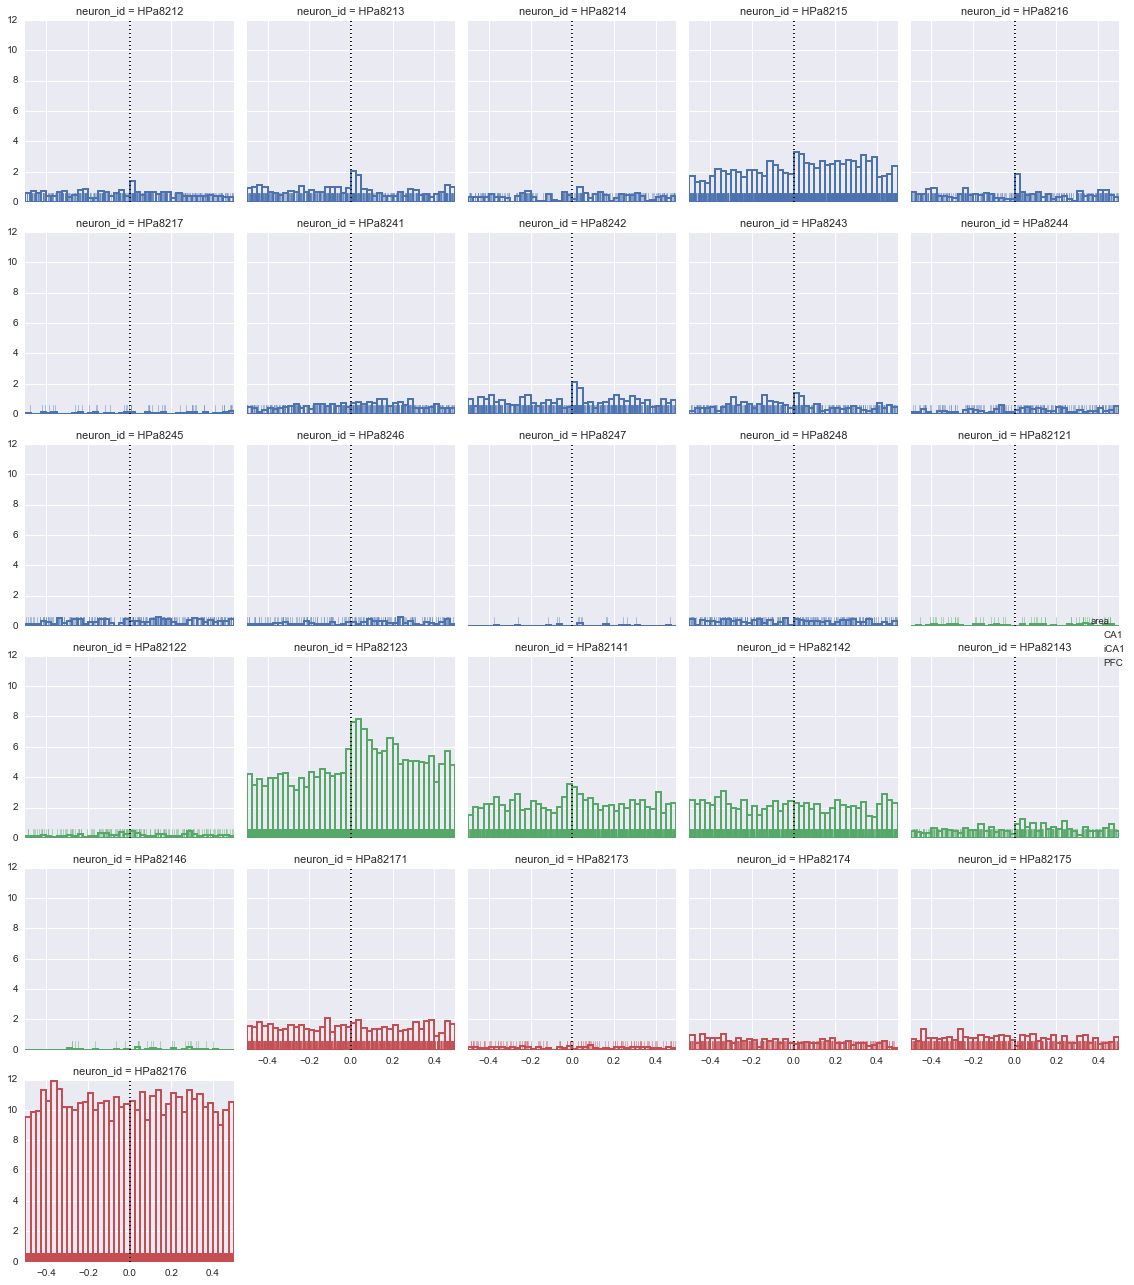

In [20]:
grid = sns.FacetGrid(frank_labeled_spike_segments.reset_index(), col='neuron_id', col_wrap=5, hue='area')
grid.map_dataframe(peth_wrap, window_offset, len(frank_ripple_times), rug=True)
grid.set(xlim=window_offset);
grid.add_legend();
grid.map(plt.axvline, x=0, color='black', ls=':')

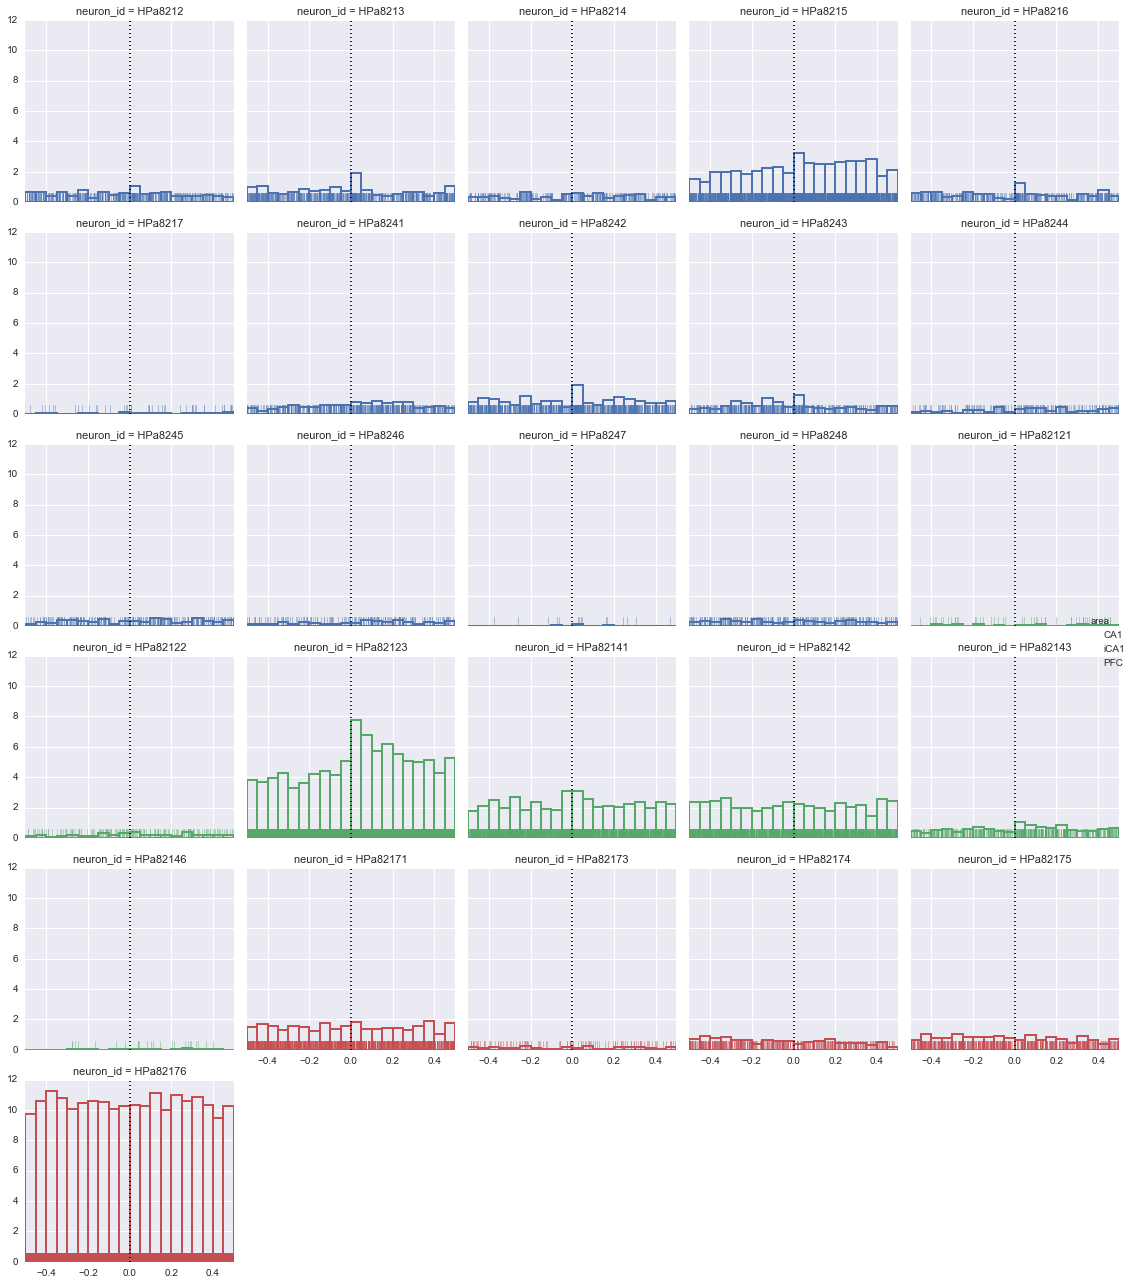

In [21]:
grid = sns.FacetGrid(frank_labeled_spike_segments.reset_index(), col='neuron_id', col_wrap=5, hue='area')
grid.map_dataframe(peth_wrap, window_offset, len(frank_ripple_times), rug=True, bin_size=0.050)
grid.set(xlim=window_offset);
grid.add_legend();
grid.map(plt.axvline, x=0, color='black', ls=':')

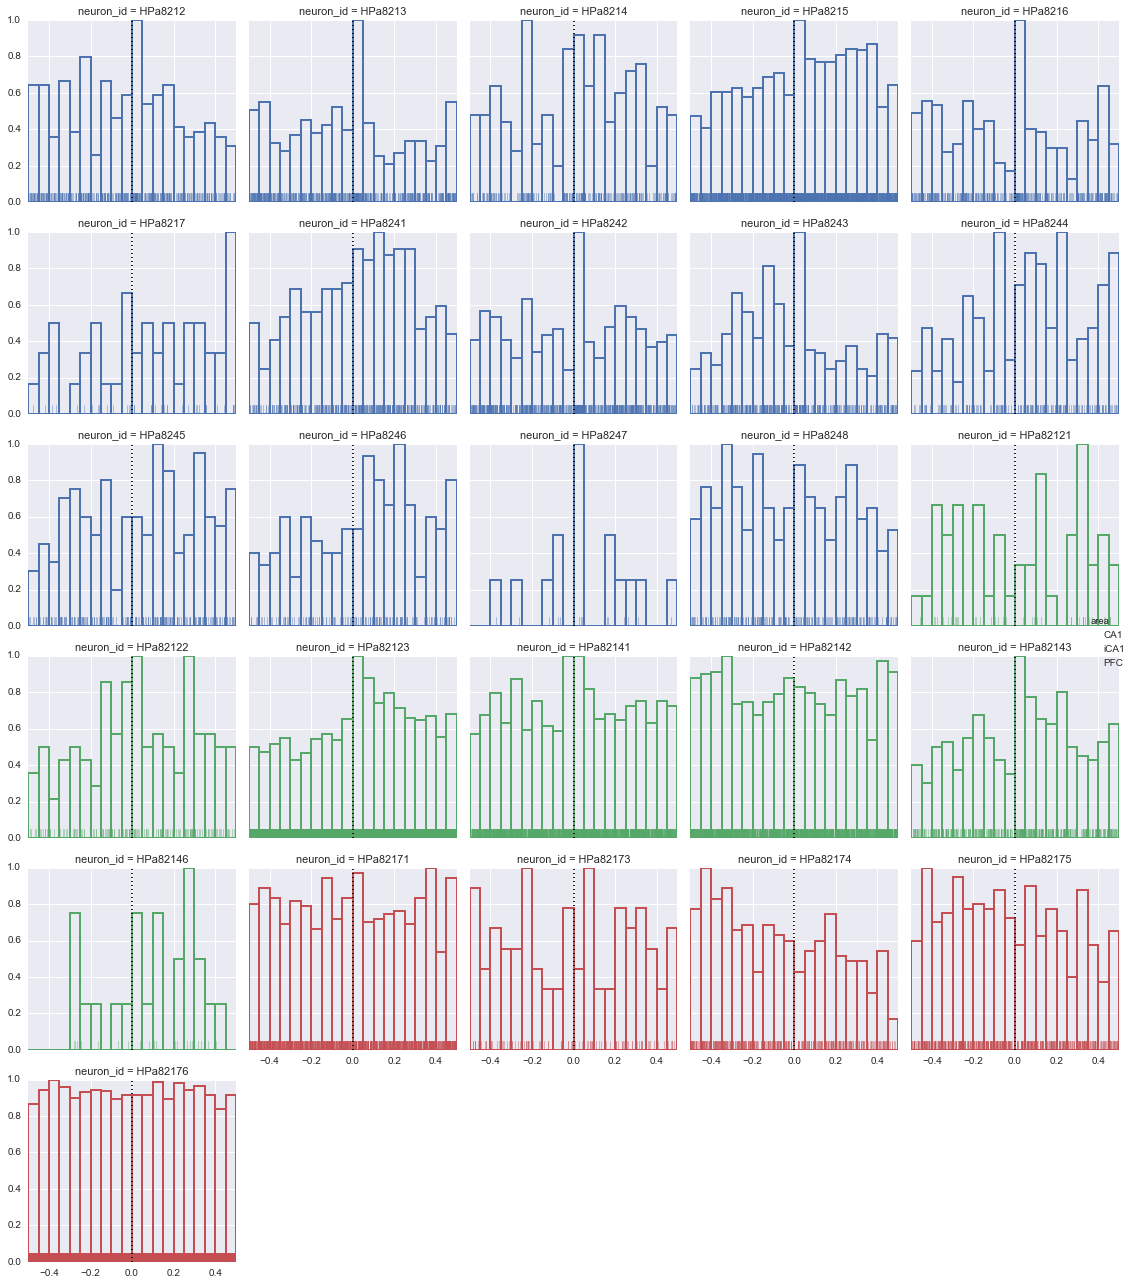

In [22]:
grid = sns.FacetGrid(frank_labeled_spike_segments.reset_index(), col='neuron_id', col_wrap=5, hue='area')
grid.map_dataframe(peth_wrap, window_offset, len(frank_ripple_times), rug=True, bin_size=0.050, normalized=True)
grid.set(xlim=window_offset);
grid.add_legend();
grid.map(plt.axvline, x=0, color='black', ls=':')

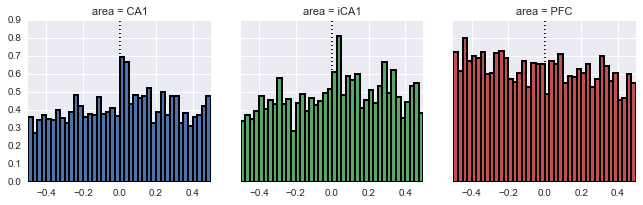

In [23]:
population_rate = compute_population_rate(frank_labeled_spike_segments, window_offset, len(frank_ripple_times))
grid = sns.FacetGrid(population_rate.reset_index(),
                     col='area', col_wrap=5, hue='area',
                     col_order=['CA1', 'iCA1', 'PFC'],
                     hue_order=['CA1', 'iCA1', 'PFC'])
grid.map(plt.bar, 'time', 'rate', width=0.025,
         linewidth=2)
grid.map(plt.axvline, x=0, color='black', ls=':')
grid.set(xlim=window_offset)

## Ripple Spectrum

In [33]:
ripple_df = (pd.DataFrame({'time': np.array(ripple_times)[:, 0], 'is_ripple': 1})
              .set_index('time')
              .reindex(index=lfp_data[0].index.values,
                       tolerance=0.0001,
                       method='nearest',
                       fill_value=0))

print(ripple_df)
print(ripple_df[ripple_df.is_ripple == 1])

             is_ripple
time                  
2712.994800          0
2712.995467          0
2712.996133          0
2712.996800          0
2712.997467          0
2712.998133          0
2712.998800          0
2712.999467          0
2713.000133          0
2713.000800          0
2713.001467          0
2713.002133          0
2713.002800          0
2713.003467          0
2713.004133          0
2713.004800          0
2713.005467          0
2713.006133          0
2713.006800          0
2713.007467          0
2713.008133          0
2713.008800          0
2713.009467          0
2713.010133          0
2713.010800          0
2713.011467          0
2713.012133          0
2713.012800          0
2713.013467          0
2713.014133          0
...                ...
3919.994133          0
3919.994800          0
3919.995467          0
3919.996133          0
3919.996800          0
3919.997467          0
3919.998133          0
3919.998800          0
3919.999467          0
3920.000133          0
3920.000800

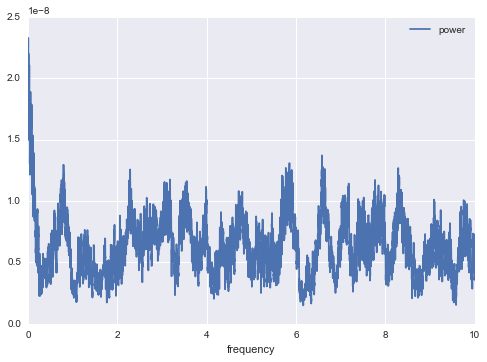

In [49]:
ripple_spectrum = pd.DataFrame(spectral.multitaper_power_spectral_density(ripple_df.is_ripple.values,
                                                                          1500,
                                                                          time_halfbandwidth_product=1,
                                                                          number_of_tapers=20,
                                                                          desired_frequencies=[0, 10]))
ripple_spectrum.plot(x='frequency', y='power')

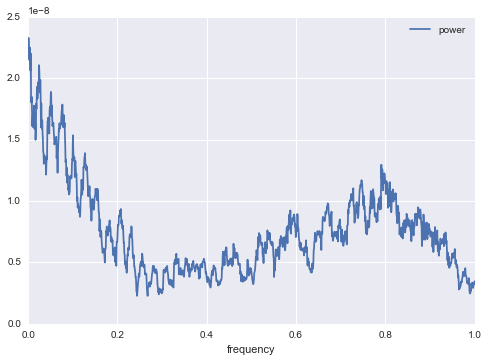

In [48]:
ripple_spectrum = pd.DataFrame(spectral.multitaper_power_spectral_density(ripple_df.is_ripple.values,
                                                                          1500,
                                                                          time_halfbandwidth_product=1,
                                                                          number_of_tapers=20,
                                                                          desired_frequencies=[0, 1]))
ripple_spectrum.plot(x='frequency', y='power')

In [35]:
frank_ripple_df = (pd.DataFrame({'time': np.array(frank_ripple_times)[:, 0], 'is_ripple': 1})
              .set_index('time')
              .reindex(index=lfp_data[0].index.values,
                       tolerance=0.0001,
                       method='nearest',
                       fill_value=0))

print(frank_ripple_df)
print(frank_ripple_df[frank_ripple_df.is_ripple == 1])

             is_ripple
time                  
2712.994800          0
2712.995467          0
2712.996133          0
2712.996800          0
2712.997467          0
2712.998133          0
2712.998800          0
2712.999467          0
2713.000133          0
2713.000800          0
2713.001467          0
2713.002133          0
2713.002800          0
2713.003467          0
2713.004133          0
2713.004800          0
2713.005467          0
2713.006133          0
2713.006800          0
2713.007467          0
2713.008133          0
2713.008800          0
2713.009467          0
2713.010133          0
2713.010800          0
2713.011467          0
2713.012133          0
2713.012800          0
2713.013467          0
2713.014133          0
...                ...
3919.994133          0
3919.994800          0
3919.995467          0
3919.996133          0
3919.996800          0
3919.997467          0
3919.998133          0
3919.998800          0
3919.999467          0
3920.000133          0
3920.000800

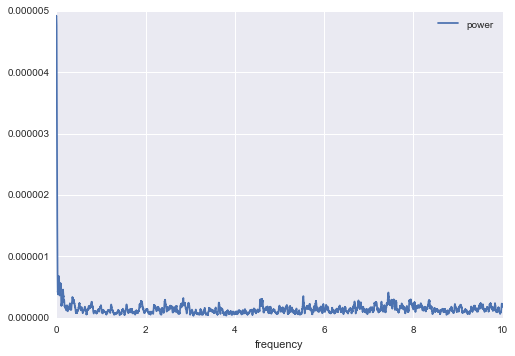

In [50]:
frank_ripple_spectrum = pd.DataFrame(spectral.multitaper_power_spectral_density(frank_ripple_df.is_ripple.values,
                                                                                1500,
                                                                                time_halfbandwidth_product=1,
                                                                                number_of_tapers=20,
                                                                                desired_frequencies=[0, 10]))
frank_ripple_spectrum.plot(x='frequency', y='power')

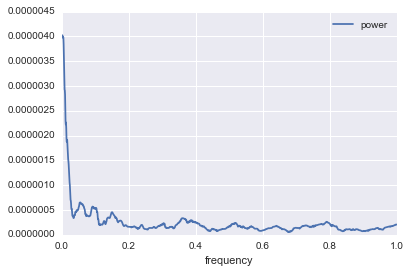

In [188]:
frank_ripple_spectrum = pd.DataFrame(spectral.multitaper_power_spectral_density(frank_ripple_df.is_ripple.values - frank_ripple_df.is_ripple.values.mean(),
                                                                                1500,
                                                                                time_halfbandwidth_product=1,
                                                                                number_of_tapers=20,
                                                                                desired_frequencies=[0, 1]))
frank_ripple_spectrum.plot(x='frequency', y='power')

## Normalized Ripple Triggered Average

### Non-normalized

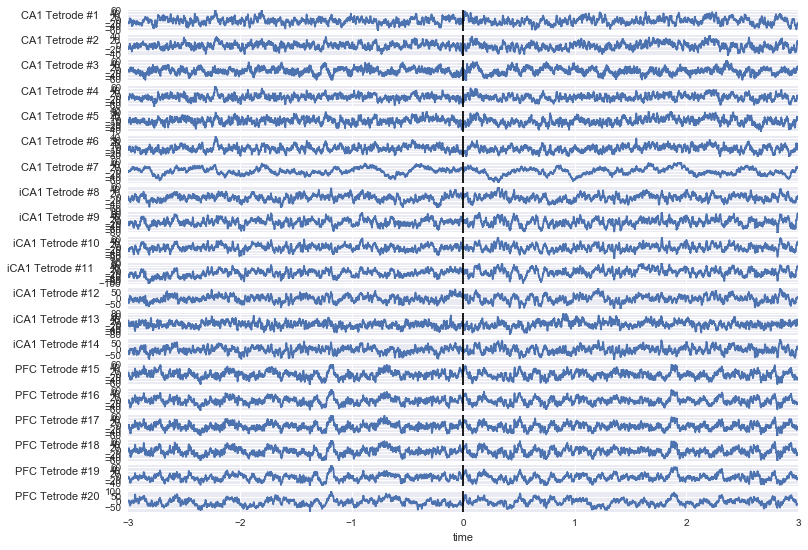

In [61]:
window_of_interest = (-3.000, 3.000)
time_of_interest_lfp_segments = list(ripples.reshape_to_segments(lfp_data, ripple_times,
                                                                 window_of_interest))

ripple_triggered_average = [lfp.reset_index().groupby('time').electric_potential.mean()
                             for lfp in time_of_interest_lfp_segments]
num_lfps = len(ripple_triggered_average)

fig, axis_handles = plt.subplots(num_lfps, 1, figsize=(12, 9), sharex=True)

# LFP
for ind in range(0, num_lfps):
    ripple_triggered_average[ind].plot(ax=axis_handles[ind], legend=False)
    axis_handles[ind].axvline(0, color='black')
    axis_handles[ind].set_ylim((ripple_triggered_average[ind].min(),
                                ripple_triggered_average[ind].max()))
    axis_handles[ind].set_ylabel(spectral.tetrode_title(tetrode_index[ind], cur_tetrode_info),
                                 horizontalalignment='right',
                                 rotation='horizontal')

#### One tetrode - each ripple

area              PFC
depth              93
descrip           NaN
numcells            0
tetrode_id    HPa8215
Name: (HPa, 8, 2, 15), dtype: object


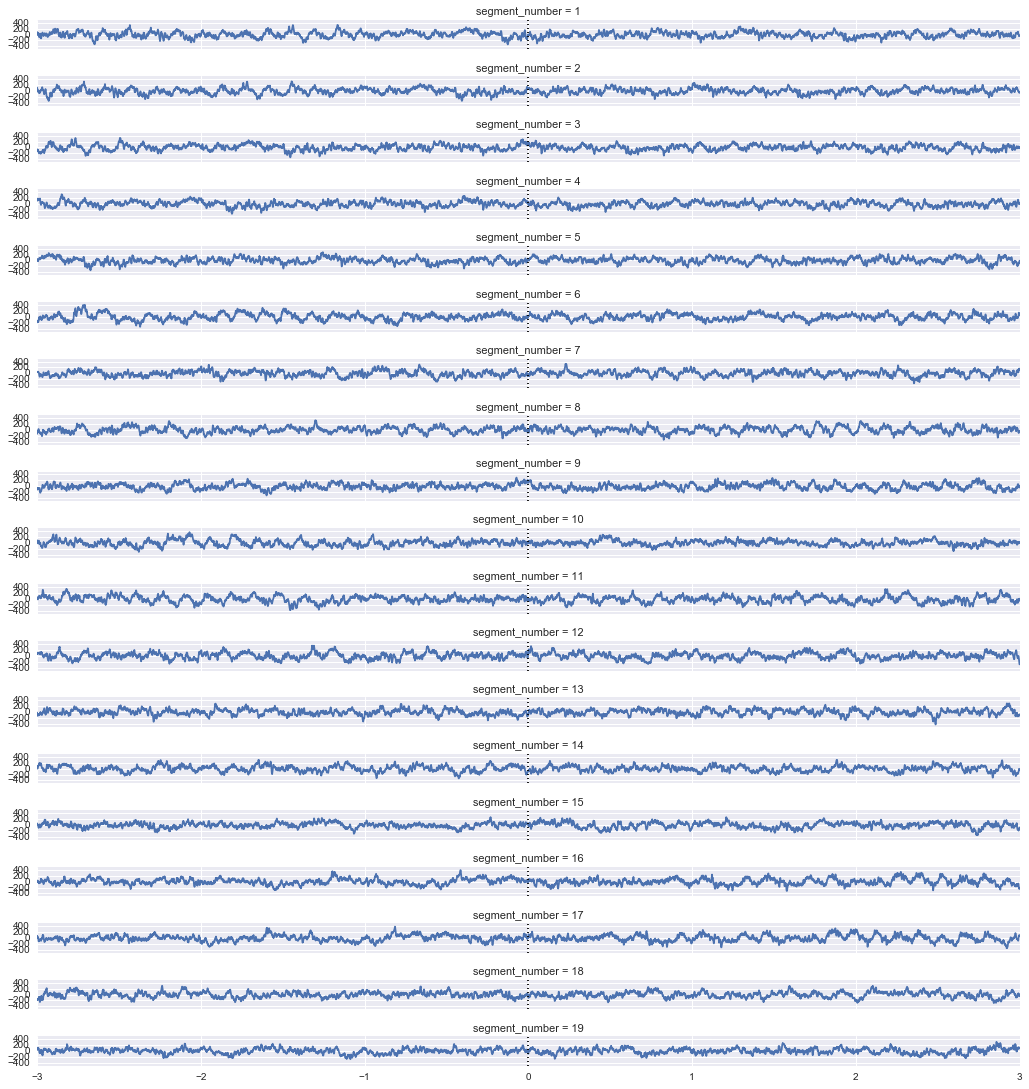

In [141]:
print(cur_tetrode_info.iloc[14])
grid = sns.FacetGrid(time_of_interest_lfp_segments[14].reset_index(),
                     row='segment_number',
                     size=0.8,
                     aspect=18)
grid.map(plt.plot, 'time', 'electric_potential')
grid.map(plt.axvline, x=0, color='black', ls=':')

area              PFC
depth              90
descrip           NaN
numcells            0
tetrode_id    HPa8216
Name: (HPa, 8, 2, 16), dtype: object


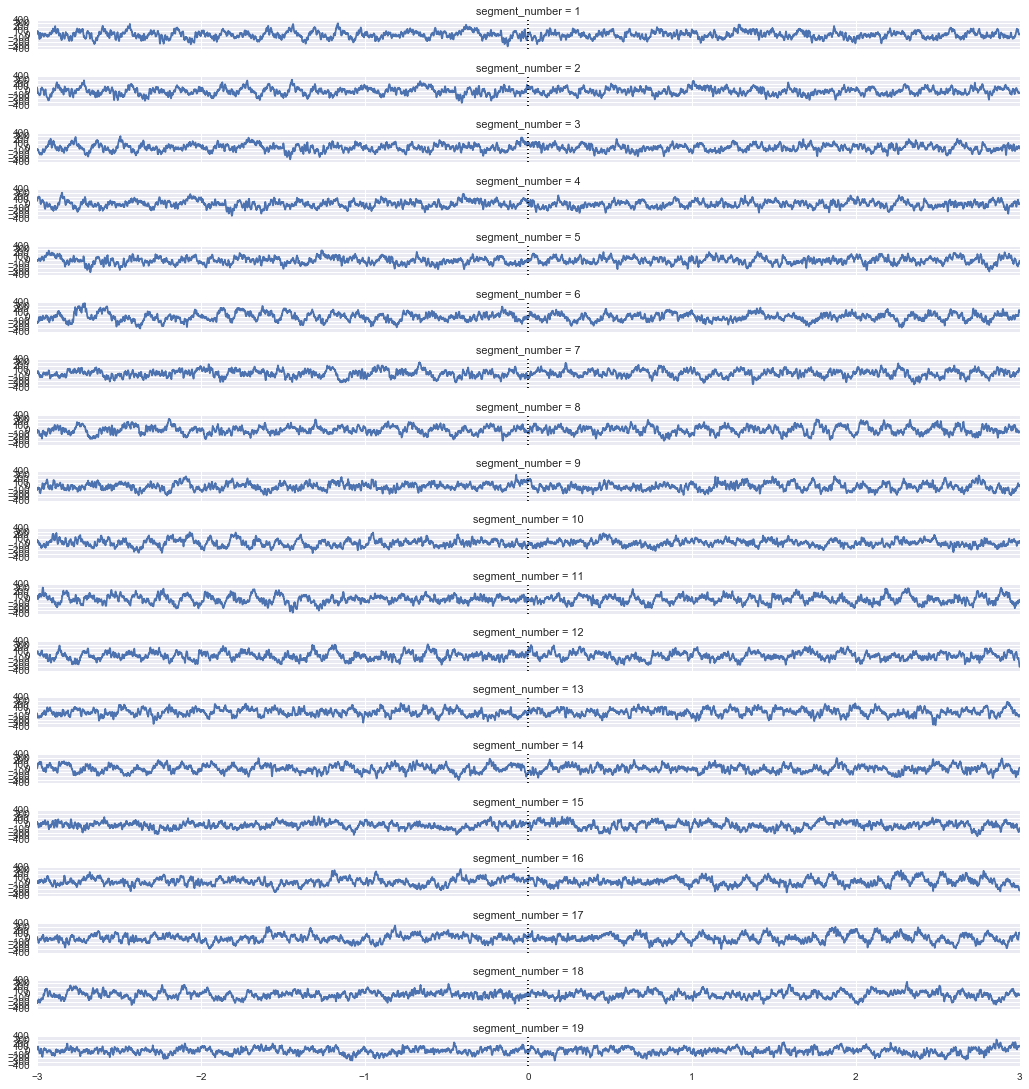

In [142]:
print(cur_tetrode_info.iloc[15])
grid = sns.FacetGrid(time_of_interest_lfp_segments[15].reset_index(),
                     row='segment_number',
                     size=0.8,
                     aspect=18)
grid.map(plt.plot, 'time', 'electric_potential')
grid.map(plt.axvline, x=0, color='black', ls=':')

#### Random segment of trial

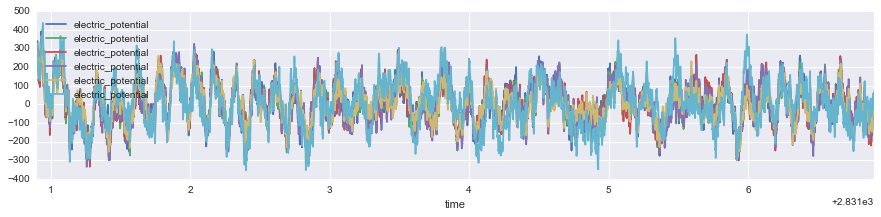

In [186]:
fig, axis_handles = plt.subplots(1, 1, figsize=(15, 3), sharex=True)
sample_time = random.sample(set(lfp_data[0].index.values), 1)[0]
for ind in np.arange(14, 20):
    lfp_data[ind].loc[sample_time:sample_time+6].plot(ax=axis_handles)
    

### Normalized

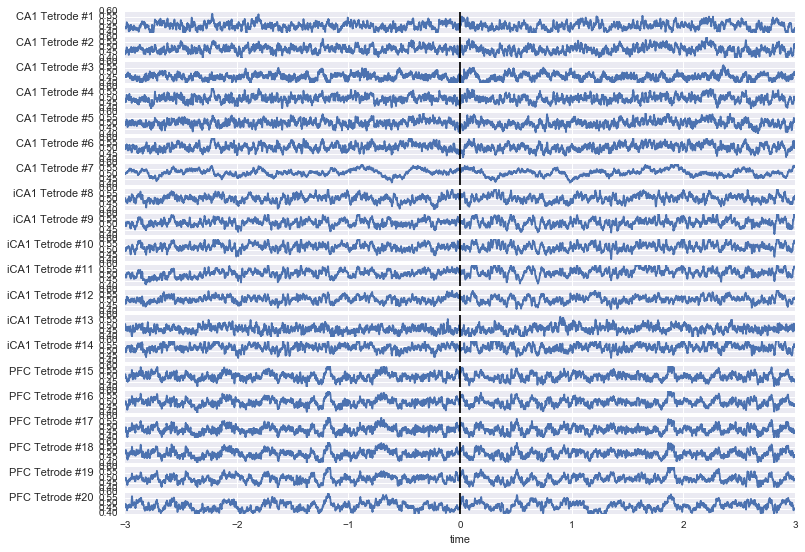

In [129]:
window_of_interest = (-3.000, 3.000)
time_of_interest_lfp_segments = list(ripples.reshape_to_segments(lfp_data, ripple_times,
                                                                 window_of_interest))

def normalize_0_1(x):
    '''Normalized between 0 and 1'''
    return (x - x.min()) / (x.max() - x.min())

def normalize_ripple_lfp(dataframe):
    return (dataframe
             .reset_index('segment_number')
             .groupby('segment_number')
                 .transform(normalize_0_1)
             .reset_index('time')
             .groupby('time')
             .mean())
    

ripple_triggered_average = [normalize_ripple_lfp(lfp)
                            for lfp in time_of_interest_lfp_segments]
num_lfps = len(ripple_triggered_average)

fig, axis_handles = plt.subplots(num_lfps, 1, figsize=(12, 9), sharex=True)

# LFP
for ind in range(0, num_lfps):
    ripple_triggered_average[ind].plot(ax=axis_handles[ind], legend=False)
    axis_handles[ind].axvline(0, color='black')
    axis_handles[ind].set_ylim((0.4, 0.6))
    axis_handles[ind].set_ylabel(spectral.tetrode_title(tetrode_index[ind], cur_tetrode_info),
                                 horizontalalignment='right',
                                 rotation='horizontal')

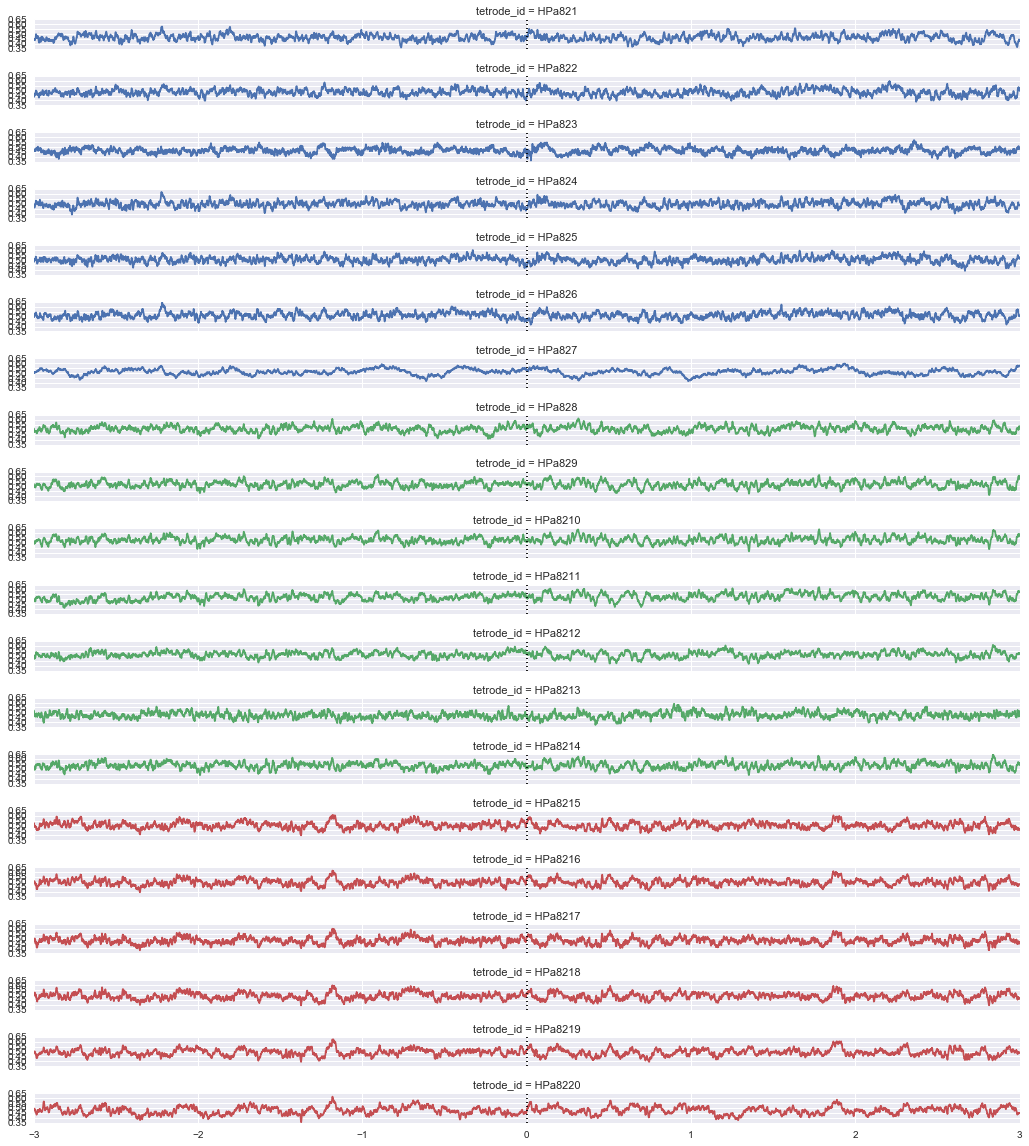

In [128]:
tetrode_labels = cur_tetrode_info.set_index(['area', 'tetrode_id'], append=True).index
labeled_ripple_triggered_average = pd.concat(ripple_triggered_average,
                                   keys=tetrode_labels,
                                   names=tetrode_labels.names)

grid = sns.FacetGrid(labeled_ripple_triggered_average.reset_index(),
                     row='tetrode_id',
                     hue='area',
                     size=0.8,
                     aspect=18)
grid.map(plt.plot, 'time', 'electric_potential')
grid.map(plt.axvline, x=0, color='black', ls=':')